## Variational AutoEncoder

### Import Libraries

In [1]:
import numpy as np
import torch
from torch import nn

import torchvision.datasets as datasets
from torch.utils.data import DataLoader

from torchvision import transforms
from torchvision.utils import save_image

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random

### Dataset

In [2]:
dataset = datasets.MNIST(root=".", train=True, transform=transforms.ToTensor(), download=True)

In [3]:
def show_imgs(dataset, r=3, c=4):
    plt.figure(figsize=(2*c, 2*r))
    for _r in range(r):
        for _c in range(c):
            plt.subplot(r, c, _r*c + _c + 1)
            ix = random.randint(0, len(dataset)-1)
            img, label = dataset[ix]
            plt.imshow(img.squeeze(0), cmap='gray')
            plt.axis("off")
            plt.title(label)
    plt.tight_layout()
    plt.show()

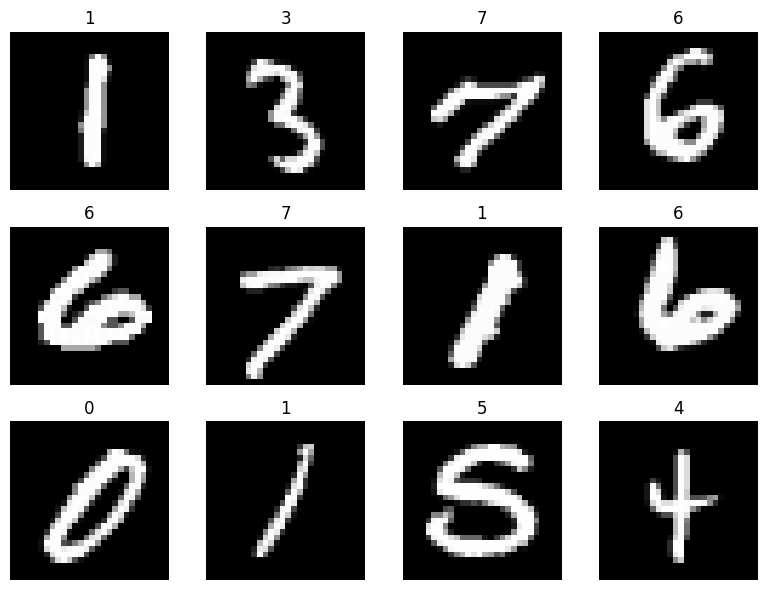

In [4]:
show_imgs(dataset)

### Model

In [5]:
class VAE(nn.Module):
    
    def __init__(self, in_dim, hidden_dim=200, z_dim=20):
        super().__init__()
        # encoder init
        self.img_to_hid = nn.Linear(in_dim, hidden_dim)
        self.hidden_to_mu = nn.Linear(hidden_dim, z_dim)
        self.hidden_to_sigma = nn.Linear(hidden_dim, z_dim)

        # decoder init
        self.z_to_hidden = nn.Linear(z_dim, hidden_dim)
        self.hidden_to_img = nn.Linear(hidden_dim, in_dim)

        # activation functions init
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    # Encoder Function
    def encode(self, x):
        hidden = self.relu(self.img_to_hid(x))
        mu, sigma = self.hidden_to_mu(hidden), self.hidden_to_sigma(hidden)
        return mu, sigma

    # Decoder Function
    def decode(self, z):
        hidden = self.relu(self.z_to_hidden(z))
        return self.sigmoid(self.hidden_to_img(hidden))

    # Forward
    def forward(self, x):
        mu, sigma = self.encode(x)
        epsilon = torch.rand_like(sigma)
        z_new = mu + sigma*epsilon
        x_rec = self.decode(z_new)          # x reconstructed
        return x_rec, mu, sigma

### Model dimensions check

In [6]:
x = torch.randn(4, 28*28)
vae_model = VAE(in_dim=784)
x_rec, mu, sigma = vae_model(x)
print(f"x_rec: {x_rec.shape} mu: {mu.shape}, sigma: {sigma.shape}")

x_rec: torch.Size([4, 784]) mu: torch.Size([4, 20]), sigma: torch.Size([4, 20])


### Config

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

in_dim = 784
h_dim = 200
z_dim = 20
epochs = 51

batch_size = 32
lr = 3e-4

### Dataloader

In [8]:
train_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

### Fit Function

In [9]:
model = VAE(in_dim, h_dim, z_dim)
checkpoint = torch.load('weights/best_model_100epochs.pth')
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [10]:
def fit(model, train_loader, in_dim, epochs):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.BCELoss(reduction="sum")
    train_losses = []
    for epoch in range(epochs):
        model.train()
        train_loss = []
        loop = tqdm(train_loader)
        for step, (x, _) in enumerate(loop):
            # Forward pass
            x = x.to(device).view(x.shape[0], in_dim)
            x_rec, mu, sigma = model(x)

            # Compute loss
            rec_loss = loss_fn(x_rec, x)         # reconstruction loss      
            kl_div = -torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))

            # Backprop
            loss = rec_loss + kl_div
            train_loss.append(loss.item())
            mean_tl = np.mean(train_loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loop.set_description(f"Loss {mean_tl}")

            if epoch % 5 == 0 and step == 0 and epoch != 0:
                print(f"Epoch {epoch} | step {step:03d} Loss: {mean_tl}")
                torch.save(model.state_dict(), 'weights/best_model_150epochs.pth')
                print("WEIGHTS-ARE-SAVED")
        train_losses.append(mean_tl)
    return train_losses

### Training

In [11]:
# train_losses = fit(model, train_loader, in_dim, epochs)

### Plotting Loss

In [12]:
def plot_loss(train_losses):
    plt.plot(train_losses , label = 'train_loss')
    plt.xlabel('No of Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [13]:
# plot_loss(train_losses)

### Inference

In [14]:
# Generates (num_examples) of a particular digit.
model = model.to("cpu")
def inference(digit, num_examples=1):
    images = []
    idx = 0
    for x, y in dataset:
        if y == idx:
            images.append(x)
            idx += 1
        if idx == 10:
            break

    encodings_digit = []
    for d in range(10):
        with torch.no_grad():
            mu, sigma = model.encode(images[d].view(1, 784))
        encodings_digit.append((mu, sigma))

    mu, sigma = encodings_digit[digit]
    for example in range(num_examples):
        epsilon = torch.randn_like(sigma)
        z = mu + sigma * epsilon
        out = model.decode(z)
        out = out.view(-1, 1, 28, 28)
        save_image(out, f"generated/generated_{digit}_ex{example}.png")

In [15]:
for idx in range(10):
    inference(idx, num_examples=5)